## Classification of Speech Frames
PART IV: RECOGNIZE A PHONEME FROM FILTERBANK FEATURES WITH A DNN

### 1. Setting up your Python Environment

1. Import Python's Machine Learning Stack and other utilities

2. Quite a few helper routines are defined for learning our Neural Network in Pytorch in the pyspch.nn module.

#### ISSUES: 
- 30/03/2022:   problem opening/importing current version on PC/windows 'code editor out of sync'


In [53]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import torch
from scipy.fftpack import dct
#from IPython.display import display

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)

# pyspch
try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/pyspch.git@v0.6
except:
  IN_COLAB = False

# pyspch
import pyspch
import pyspch.nn
logging.basicConfig(level=logging.INFO)

In [42]:
#@title Auxiliary functions 

import requests
import importlib
import scipy.io as sio
import urllib.request
import pickle
import gzip

# download from url and write to file
def write_from_url(url, filename):
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)

# dictionairy
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def dict_from_module(module):
    context = {}
    for setting in dir(module):
        # you can write your filter here
        if not setting.startswith('_'):
            context[setting] = getattr(module, setting)

    return context

# import setup file (.py) as module (dotdict)
def read_setup(filename):
    spec = importlib.util.spec_from_file_location(os.path.basename(filename), filename)
    setup = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(setup)
    
    # convert to dict 
    setup = dict_from_module(setup)
    setup = dotdict(setup)
    
    return setup

# loads all data in a matlab file at given url to the contents structure
# this is working for MATLAB 7.0 files and older ; not hdf5 MATLAB 7.3 or more recent
def load_matlab_from_url(url):
    url_response = urllib.request.urlopen(url)
    matio = io.BytesIO(url_response.read())
    contents = sio.loadmat(matio,squeeze_me=True)
    return(contents)

In [3]:
# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

### Baseline DNN model

We use a simple Neural Network (NN) to classify the frames, namely a fully connected feed-forward network, with a sigmoid activation function following each hidden layer. The architecture is defined by the input, output and hidden layer sizes. 

The input feature is a window of 11 frames (black) around the target frame (red) with a stride of 2, giving window that spans 210 ms. 
The stride is distance (in time steps) between the selected frames. 
For each target frames, the selected frames are concatenated into a vector.
Alternatively, one could preserve the 2D structure of the input (time x frequency) provided the neural architecture allows it (e.g. using 2D convolutional layers). 

The phone labels are one-hot encoded, we thus have a neuron for each phone label in the output layer of the network. By applying the softmax function at the end of the network, we obtain phone probabilities as outputs. The predicted label is the one with the highest probabilty. 

Note that training a model from scratch on TIMIT is (relatively) computationally expensive. That is why we load a pretrained model, matching the architecture described above.

<img src="http://homes.esat.kuleuven.be/~spchlab/data_old/timit/dnn_setup_3.PNG" width="750">

#### Setup for baseline


In [4]:
# root url
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'

# baseline path
baseline_path = 'models/baseline/'
baseline_path = 'models/dummy/'
os.makedirs(baseline_path, exist_ok=True, mode=0o777)

# setup file
write_from_url(root_url + baseline_path + 'setup.py', baseline_path + 'setup.py')
write_from_url(root_url + baseline_path + 'model.pt', baseline_path + 'model.pt')

In [33]:
# read setup 
setup = read_setup(baseline_path + 'setup.py')
#path.replace('/users/spraak/spchlab/public_html/', root_url)

# read checkpoint (model)
checkpoint = pyspch.nn.read_checkpoint(baseline_path + 'model.pt', device)
model_setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
model = pyspch.nn.get_model(model_setup['model_args'])
model.to(device)

# update setup - allows continued training
setup.update(model_setup)

#### Data loading

Apart from using a window of frames as input feature for each target frame, we can also normalize and add temporal derrivatives to input feature. 
Here we normalize the variance per channel (and per utterance) and add a first order temporal derrivative (called delta).  

Next we prepare our test data set according to our feature extraction setup.
Note we don't need the training or validation data since we're using a pretrained model.

In [54]:
# feature arguments
# feature_path = root_url + 'features/mel24/'
read_feature_args = pyspch.read_json(setup.feature_path + 'feature_args.json')
modify_feature_args = pyspch.dct_diff(read_feature_args, setup.feature_args)

In [26]:
# label mapping 
labels = pyspch.timit.get_timit_alphabet(setup.labset_out)
lab2lab = pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 
lab2idx = {k: i for i, k in enumerate(labels)} 
print(lab2idx)

{'aa': 0, 'ae': 1, 'ah': 2, 'ao': 3, 'aw': 4, 'er': 5, 'ay': 6, 'b': 7, 'ch': 8, 'd': 9, 'dh': 10, 'eh': 11, 'm': 12, 'ng': 13, 'ey': 14, 'f': 15, 'g': 16, 'hh': 17, 'ih': 18, 'iy': 19, 'jh': 20, 'k': 21, 'l': 22, 'n': 23, 'ow': 24, 'oy': 25, 'p': 26, 'r': 27, 's': 28, 'sh': 29, 't': 30, 'th': 31, 'uh': 32, 'uw': 33, 'v': 34, 'w': 35, 'y': 36, 'z': 37, 'zh': 38, 'sil': 39, 'cl': 40}


In [35]:
# Prepare test set (evaluation)

# corpus
test_corpus = pyspch.read_txt(setup.test_corpus_file)

# read features 
test_df = pd.read_pickle(setup.test_pickle_file)
test_data = pyspch.nn.DataFrame_to_SpchData(test_df, delete_df=True) 

# modify features in corpus
test_data = test_data.subset(test_corpus) 
test_data.modify_features(modify_feature_args) 

# SpchDataset
test_ds = pyspch.nn.SpchDataset(test_data.corpus, test_data.features, test_data.labels)
test_ds.map_target(lab2lab) # timit61 -> timit41
test_ds.encode_target(lab2idx) # one-hot encoding
test_ds.to_tensor()

# Sampler (splicing)
test_lengths = test_data.get_length('features')
test_ds.set_sampler(test_lengths, setup.sampler_args)
test_ds.to_device(device)

# DataLoader
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)

#### Baseline model evaluation

##### Test set: PER and confusion matrix

PER 0.99 
CEL 4.05


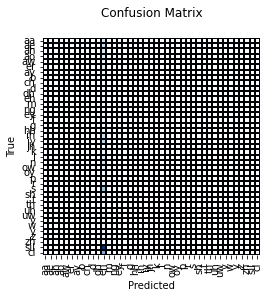

(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix\n'}, xlabel='Predicted', ylabel='True'>)

In [36]:
# Confusion matrix
cm = pyspch.nn.evaluate_cm(model, test_dl) 

# Phone Error Rate (PER) + PER per phone class
per, per_pc = pyspch.nn.cm2per(cm)
print("PER %.2f " % (per))
if not None in per_pc:
    print("PER per phone class %s" % (np.round(per_pc, 4)))

# Cross-entropy loss
loss = pyspch.nn.evaluate(model, test_dl, criterion)
print("CE Loss %.2f" % loss)

# plot
pyspch.plot_confusion_matrix(cm, labels, annot=False)

##### Single utterance: phone probabilties

The posterior probabilties are now visualized for one entire utterance below. Because the dataset (after feature extraction) is quite big, we avoid loading unnecessary data. Here we only do the feature extraction for a single utterance.

In [37]:
# select file to visualize
example = 'test/dr1/faks0/si2203'

# transcription + word segmentation 
example_txt = pyspch.read_txt(setup.label_path + example + ".txt")
example_wrd = pyspch.read_dataframe(setup.label_path + example + ".wrd", sep=" ", names=['t0','t1','wrd'])

# labels (phone segmentation)
lab_shift = read_feature_args['f_shift'] * read_feature_args['sample_rate']
example_phn = pyspch.timit.read_seg_file(setup.label_path + example + ".phn", fmt="float32")
example_lab = pyspch.seg2lbls(example_phn, lab_shift) #length !!!
example_lab = [lab2lab[lbl] for lbl in example_lab]
example_idx = [lab2idx[lbl] for lbl in example_lab] # target

# audio
example_audio, _ = pyspch.audio.load(root_url + 'audio/' + example + ".wav", sample_rate=lab_shift)

# feature + modification + splicing
example_feature = np.load(pyspch.read_fobj(setup.feature_path + example + '.npy'))
example_mod = pyspch.sp.feature_extraction(spg=example_feature, **modify_feature_args)
example_spliced = pyspch.sp.splice_frames(example_mod, setup.sampler_args['N'], setup.sampler_args['stride']) # input

# tensor
example_X = torch.tensor(example_spliced).T.float().to(device)
example_y = torch.tensor(example_idx).long().to(device)

# prediction 
example_yp = model(example_X) # log probs
example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs

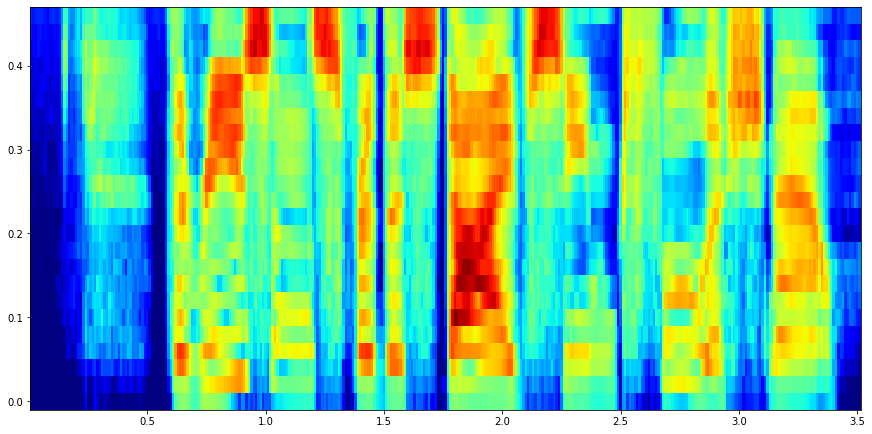

In [38]:
# Visualization
pyspch.display.PlotSpg(spgdata=example_feature, segspg=example_phn)

<AxesSubplot:title={'center':'Predicted phone probabilties'}>

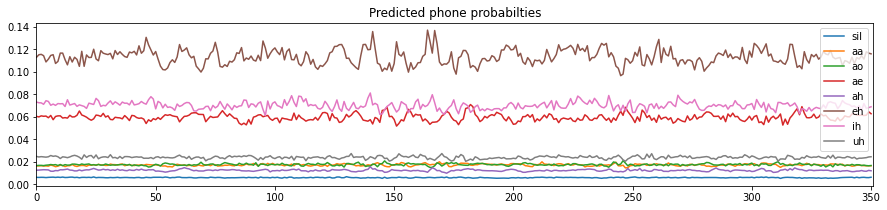

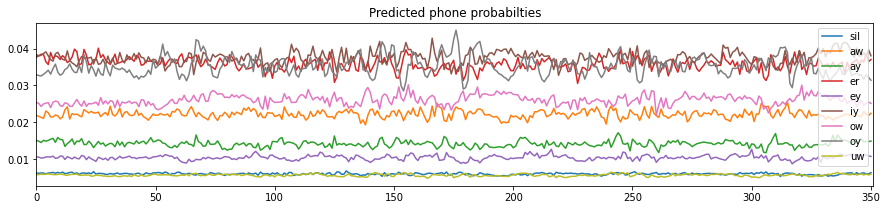

In [41]:
# plot only subset of phones (for readability)
long_vowels = ['aw', 'ay', 'er', 'ey', 'iy', 'ow', 'oy', 'uw']
short_vowels = ['aa', 'ao', 'ae', 'ah', 'eh', 'ih', 'uh']

# plot input
if False:
  utt_fig, utt_ax = plt.subplots(figsize=(15, 10))
  utt_ax.matshow(example_X.cpu().detach().numpy().T)

# plot output - posterior probabilities
plot_df = pd.DataFrame(example_yp.cpu().detach().numpy(), columns=labels)
cols = labels
cols = ['sil'] + short_vowels # choose phones to plot (subset) 
# Note: sil = silence and vcl = 'voiced closure' ~ silence
plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3), xlim=[0, example_yp.shape[0]])

# plot output - posterior probabilities
cols = ['sil'] + long_vowels # choose phones to plot (subset) 
plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3), xlim=[0, example_yp.shape[0]])

#### Questions

**Phone mapping**

Q1. What is the effect of reducing the number of phone labels (e.g. from 61 to 48) for training the model? 

**Feature extraction**

Q2. Can we use our pretrained model with a different feature extraction setup?

Q3. What happens to the input feature on the phone boundaries?

Q4. What happens to the input feature on the utterance boundaries?

**Evaluation**

Q5. What is the effect of reducing the number of phone labels from 48 to 39 for evaluating the model? 

<!-- Q6. Given the posterior probabilities for the utterance "The reasons for this dive seemed foolish now", is there a corespondence between the short vowels that are hard to recognize for the model and your own perception? -->


### Effect of input features

Using the same model setup as above, we will now vary the feature extraction setup. Four new setups are considered. Note that we are still loading pretrained models.

#### Setups

In [43]:
# write multiple pretrained models 

# # models/architecture/feature/sampler/
# model_paths = ['models/default/mel24v/N2s2/', # 5 frames, stride 2 (100 ms)
#                'models/default/mel24v/N5s2/', # 11 frames, stride 2 (220 ms)
#                'models/default/mel24dv/N5s2/', # 11 frames, stride 2, delta (220 ms)
#                'models/default/mel24dd2v/N5s2/', # 11 frames, stride 2, delta + ddelta (220 ms) = baseline
#                'models/default/mel24/N10s1/', # 21 frames (210 ms)
#                'models/default/mel24/N7s2/', # 15 frames, stride 2 (300 ms)
#                ] 

model_paths = ['models/dummy/', # 5 frames, stride 2 (100 ms)
               'models/dummy/', # 11 frames, stride 2, delta + ddelta (220 ms) = baseline
               ] 

for model_path in model_paths:
    os.makedirs(baseline_path, exist_ok=True, mode=0o777)
    write_from_url(root_url + model_path + 'setup.py', model_path + 'setup.py')
    write_from_url(root_url + model_path + 'model.pt', model_path + 'model.pt')

#### Evaluate and visualize 

{'window_nframes': 7, 'stride': 2, 'shift': 0, 'delta': False, 'ddelta': False, 'normMean': False, 'normVar': True}
{'window_nframes': 7, 'stride': 1, 'shift': 0, 'delta': True, 'ddelta': False, 'normMean': False, 'normVar': True}
{'window_nframes': 13, 'stride': 1, 'shift': 0, 'delta': False, 'ddelta': False, 'normMean': False, 'normVar': True}
{'window_nframes': 13, 'stride': 2, 'shift': 0, 'delta': False, 'ddelta': False, 'normMean': False, 'normVar': True}


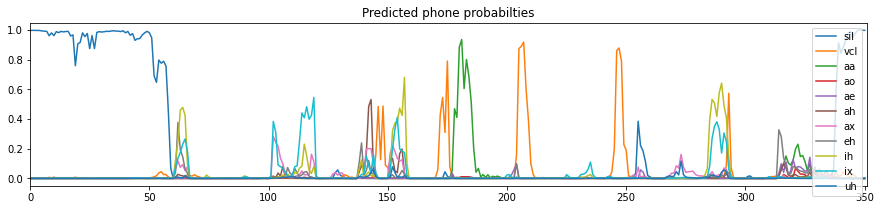

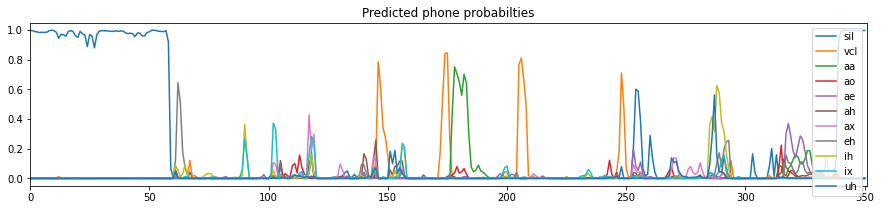

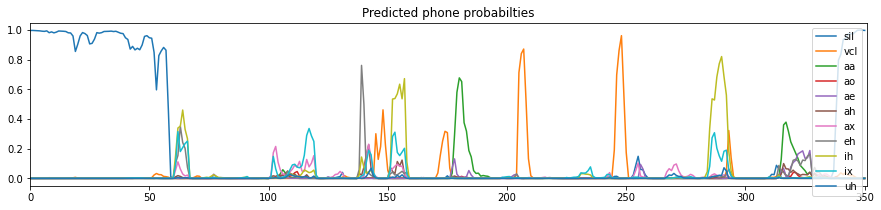

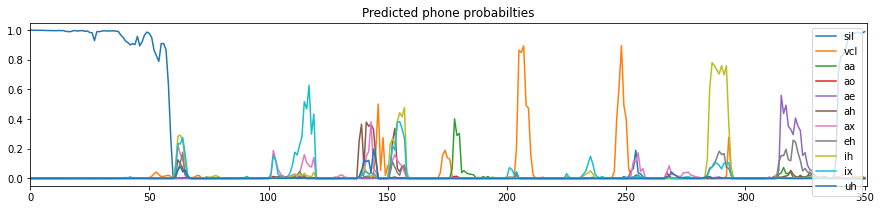

In [ ]:
# shared (base) feature = mel24
test_corpus = pyspch.read_txt(setup.test_corpus_file) # corpus
test_df = pd.read_pickle(setup.test_pickle_file) # read all features 

for model_path, setup in zip(model_paths): 
    
    ### Model
    
    # setup and model
    setup = read_setup(model_path + 'setup.py')
    model = model_setup, lab2idx, model, criterion, optimizer, scheduler = pyspch.nn.read_checkpoint(model_path + 'model.pt', device)
    model = pyspch.nn.get_model(model_setup['model_args'])  

    # feature arguments
    read_feature_args = pyspch.read_json(setup.feature_path + 'feature_args.json')
    modify_feature_args = pyspch.dct_diff(read_feature_args, setup.feature_args)
    print(setup.feature_args)
    
    # label mapping 
    labels = pyspch.timit.get_timit_alphabet(setup.labset_out)
    lab2lab = pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 
    lab2idx = {k: i for i, k in enumerate(labels)} 
    print(lab2idx)
    
    ### Single utterance: phone probabilties
    
    # utterance
    example = 'test/dr1/faks0/si2203'
    
    # labels (phone segmentation)
    lab_shift = read_feature_args['f_shift'] * read_feature_args['sample_rate']
    example_phn = pyspch.timit.read_seg_file(setup.label_path + example + ".phn", fmt="float32")
    example_lab = pyspch.seg2lbls(example_phn, lab_shift)
    example_lab = [lab2lab[lbl] for lbl in example_lab]
    example_idx = [lab2idx[lbl] for lbl in example_lab] # target
    
    # feature + modification + splicing
    example_feature = np.load(pyspch.read_fobj(setup.feature_path + example + '.npy'))
    example_mod = pyspch.sp.feature_extraction(spg=example_feature, **modify_feature_args)
    example_spliced = pyspch.sp.splice_frames(example_mod, setup.sampler_args['N'], setup.sampler_args['stride']) # input

    # tensor
    example_X = torch.tensor(example_spliced).T.float().to(device)
    example_y = torch.tensor(example_idx).long().to(device)

    # prediction 
    example_yp = model(example_X) # log probs
    example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs
    
    # plot output - posterior probabilities
    plot_df = pd.DataFrame(example_yp.cpu().detach().numpy())
    plot_df.columns = labels
    cols = plot_df.columns # choose phones to plot
    cols = ['sil'] + short_vowels # + long_vowels # 
    plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3))

    if False:
      
        ## Test set: PER and confusion matrix
        
        # modify features
        test_data = pyspch.nn.DataFrame_to_SpchData(test_df, delete_df=False)  
        test_data = test_data.subset(test_corpus) # subset by corpus
        test_data.modify_features(modify_feature_args) # modify features

        # SpchDataset
        test_ds = pyspch.nn.SpchDataset(test_data.corpus, test_data.features, test_data.labels)
        test_ds.map_target(lab2lab) # timit61 -> timit41
        test_ds.encode_target(lab2idx) # one-hot encoding
        test_ds.to_tensor()

        # Sampler (splicing)
        test_lengths = test_data.get_length('features')
        test_ds.set_sampler(test_lengths, setup.sampler_args)

        # DataLoader
        test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)
        
        # PER and confusion matrix
        loss = pyspch.nn.evaluate(model, test_dl, criterion)
        cm = pyspch.nn.evaluate_cm(model, test_dl) 
        per, per_pc = pyspch.nn.cm2per(cm)
        print("CEL %.2f" % loss)
        print("PER %.2f " % (per))
        pyspch.plot_confusion_matrix(cm, labels, annot=False)

#### Questions

**Example utterance**

Q1. Do you notice a difference in the posterior probabilities for different input features?

Q2. Evaluate the models on the test set (run this only if you have spare time). Do you notice a difference in the PER for different input features? Which feature gives the best performance, and why?


### Single frame DNN vs. GMM

Last exercise session on phoneme classification, we compared the performance of DNNs and GMMs. Near the end we remarked the toy problem was too small for meaningful conclusions. Here we compare the two models on a subset of TIMIT, namely the short vowels. 

If you want to run small experiments yourself, you can select a subset with only a couple of phonemes (reducing the size of the dataset and the diversity in labels). Here we use the short vowels.

In [ ]:
# subset of phone labels
short_vowels = ['aa', 'ao', 'ae', 'ah', 'eh', 'ih', 'uh']
long_vowels = ['aw', 'ay', 'er', 'ey', 'iy', 'ow', 'oy', 'uw']

In [ ]:
# shared (base) feature = mel24
train_corpus = pyspch.read_txt(setup.train_corpus_file) # corpus
test_df = pd.read_pickle(setup.train_pickle_file) # read all features 

#### Feature extraction

We use the same feature extraction setup ('f11s2_setup') as te baseline model.
Since we are only using the short vowels of TIMIT, examples with other labels are discarted during the feature extraction.

In [ ]:
# Prepare train/validation/test set
# ! takes around 2 minutes (~ combining frames in context window)
shortvowels_df = prepare_setup(utt_df, f11s2_setup, phn_set=phn_set)

# phone and label mapping
phn2phn, phn2lab, lab2phn, phn_set = phone_and_label_mapping(phone_map_file, ocol, phn_set)

# split data
train_df, valid_df, test_df = utterance_based_data_split(shortvowels_df)

# input features
dnn_train_X = np.vstack(train_df['feature']).astype('float32') 
dnn_valid_X = np.vstack(valid_df['feature']).astype('float32') 
dnn_test_X = np.vstack(test_df['feature']).astype('float32') 

# labels
train_y = train_df['int_label'].to_numpy().astype('int64') 
valid_y = valid_df['int_label'].to_numpy().astype('int64')
test_y = test_df['int_label'].to_numpy().astype('int64')

#### DNN model


##### Setup for single frame DNN

We use the same model setup as above, except the output layer size which matches the new number of labels (number of short vowels). Since we are no longer loading a pretrained model, you can experiment with different the hidden layers. 

For training the neural network we use mini-batch gradient decent with early stopping. This means training is halted when the the loss on the validation set has not improved for 'patience' epochs.


In [ ]:
# define setup
setup = dotdict()

# corpus
setup.train_corpus_file = root_url + 'conf/timit_train_dummy.corpus'
setup.test_corpus_file = root_url + 'conf/timit_test.corpus' 
# features
setup.feature_path = root_url + 'features/mel24/'
setup.feature_args =  {
    'spg': None,
    'Deltas': 'delta_delta2',
    'Norm': 'var',
    'sample_rate': 16000,
    'f_shift': 0.01,
    'f_length': 0.03,
    'preemp': 0.97,
    'window': 'hamm',
    'mode': 'dB',
    'n_mels': 24,
    'n_cep': None
}
# pickled dataframe (preprocessed)
setup.train_pickle_file = setup.feature_path + 'train.pkl'
setup.test_pickle_file = setup.feature_path + 'test.pkl'
# labels
setup.label_path =  root_url + 'segmentation/'
setup.label_args = {
    'extension': '.phn', 
    'pad': 'h#',
    }
setup.labset_in = "timit61"
setup.labset_out = "timit41"
# meta labels
setup.meta_label_args = None
# SpchDataset
setup.sampler_args = {
    'N': 1,
    'stride': 0,
    'mode': 'flatten',
    }
# model
setup.model_args = {
    'model': 'ffdnn',
    'model_args': {
        'in_dim': 24 * 3,
        'out_dim': 41,
        'hidden_layer_dims': [512, 256],
        'nonlinearity': 'sig',
        'dropout': 0.1
        }
    }
setup.use_cuda_if_available = True
# training
setup.current_epoch = 0
setup.print_every = 1
setup.training_args = {
    'n_epoch': 250,
    'patience': 20,
    'criterion': 'crossentropy',
    'criterion_args': {},
    'optimizer': 'adamw',
    'optimizer_args': {
        'lr': 0.001,
        },
    'scheduler': 'plateau',
    'scheduler_args': {
        'factor': 0.1,
        'patience': 10,
        'threshold': 0.0001
        },
    'clip_args': {},
    'batch_size': 64,
    'shuffle': True,
    'num_workers': 0,
    'val_frac': 0.1,
    'val_seed': 1234,
    }
# evaluate
setup.evaluate_args = {
    'batch_size': 256,
    'shuffle': False,
    'num_workers': 0,
    }
# output
setup.output_path = root_url + "models/ffdnn_default_mel24dd2v/sig_drop01_adamw0001/"
setup.setup_jsonfile = setup.output_path + "setup.json"
setup.model_file = setup.output_path + "model.pt"

In [52]:
# important arguments in setup 
print(' -- Feature arguments (mfcc13 + delta + delta2)')
print(setup.feature_args)
print(' -- Sampler arguments (window = single frame (N=1)')
print(setup.sampler_args)
print(' -- Model arguments (small DNN, sigmoid activation, dropout)')
print(setup.model_args)

 -- Feature arguments (mfcc13 + delta + delta2)
{'spg': None, 'Deltas': 'delta_delta2', 'Norm': 'var', 'sample_rate': 16000, 'f_shift': 0.01, 'f_length': 0.03, 'preemp': 0.97, 'window': 'hamm', 'mode': 'dB', 'n_mels': 24, 'n_cep': None}
 -- Sampler arguments (window = single frame (N=1)
{'N': 5, 'stride': 2, 'mode': 'flatten'}
 -- Model arguments (small DNN, sigmoid activation, dropout)
{'model': 'ffdnn', 'model_args': {'in_dim': 792, 'out_dim': 41, 'hidden_layer_dims': [512, 256], 'nonlinearity': 'sig', 'dropout': 0.1}}


#### Data loading

In [ ]:
# feature arguments
feature_path = root_url + 'features/mel24/'
read_feature_args = pyspch.read_json(setup.feature_path + 'feature_args.json')
modify_feature_args = pyspch.dct_diff(read_feature_args, setup.feature_args)

In [ ]:
# label mapping for subset
labels = ['sil'] + short_vowels 
lab2lab = {setup.labset_in pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 
lab2idx = {k: i for i, k in enumerate(labels)} 

# subset of labels
labels = 
print(lab2idx)


In [ ]:


# Prepare test set (evaluation)

# corpus
test_corpus = pyspch.read_txt(setup.test_corpus_file)

# read features 
test_df = pd.read_pickle(setup.test_pickle_file)
test_data = pyspch.nn.DataFrame_to_SpchData(test_df, delete_df=True) 

# modify features in corpus
test_data = test_data.subset(test_corpus) 
test_data.modify_features(modify_feature_args) 

# SpchDataset
test_ds = pyspch.nn.SpchDataset(test_data.corpus, test_data.features, test_data.labels)
test_ds.map_target(lab2lab) # timit61 -> timit41
test_ds.encode_target(lab2idx) # one-hot encoding
test_ds.to_tensor()

# Sampler (splicing)
test_lengths = test_data.get_length('features')
test_ds.set_sampler(test_lengths, setup.sampler_args)
test_ds.to_device(device)

# DataLoader
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)

##### Training

In [ ]:
# plot training and validation loss
plt.figure()
plt.plot(dnn_train_loss)
plt.plot(dnn_valid_loss)
plt.title("Training and validation loss - fully connected input layer")
plt.legend(['train', 'validation'])

##### Evaluation

In [ ]:
# compute confusionmatrix 
dnn_cm = confusionmatrix(dnn_model, dnn_test_X, test_y, device)

# phone error rate
print(evaluate_PER(dnn_cm))

KeyboardInterrupt: ignored

NameError: ignored

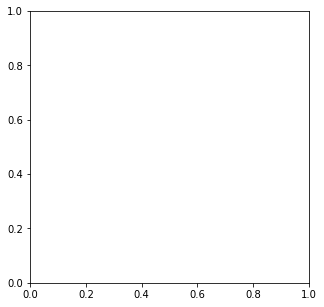

In [ ]:
# plot normalized confusion matrix
plotCm = True
if plotCm:
    from sklearn.preprocessing import normalize
    fig, ax = plt.subplots(figsize=(5, 5))
    cm_image = ax.matshow(normalize(dnn_cm, axis=0, norm='l1'), interpolation='nearest')
    fig.colorbar(cm_image, ax=ax)
    ax.set_xticklabels(['']+list(phn2lab.keys()))  
    ax.set_yticklabels(['']+list(phn2lab.keys()))

Saving the model in case you want to reuse it.

In [ ]:
# save model
!mkdir -p 'models/'
dnn_model_file = 'models/dnn_shortvowel_model.pt'
dnn_model_dict = {'epoch': dnn_epoch,
                  'model_state_dict': dnn_model.state_dict(),
                  'criterion': criterion,
                  'optimizer_state_dict': dnn_optimizer.state_dict()}
torch.save(dnn_model_dict, dnn_model_file)

#### GMM model

In [47]:
#@title GMM functions

from pyspch import GaussianMixtureClf
from sklearn import metrics as skmetrics 

# =============================================================================
# GMM
# =============================================================================

def train_test_GMM(X_train,X_test,y_train,y_test,classes,
                     n_components=1,max_iter=20,tol=1.e-3,print_result=True,print_cmat=False):
    clf_GM = GaussianMixtureClf(classes=classes,n_components=n_components,max_iter=20,tol=1.e-3)
    clf_GM.fit(X_train,y_train)
    y_pred = clf_GM.predict(X_train)
    acc_train = 100.0*skmetrics.accuracy_score(y_train, y_pred)
    y_pred = clf_GM.predict(X_test)
    acc_test = 100.0*skmetrics.accuracy_score(y_test, y_pred) 
    cmat = skmetrics.confusion_matrix(y_test,y_pred)
    if(print_result):
        lls, bics = llscore(clf_GM,X_train,y_train)
        print('Training Set:  Accuracy = %.2f%%     LL = %.2f    BIC = %.2f ' % (acc_train,lls,bics) )
        print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
    if(print_cmat):
        pyspch.plot_confusion_matrix(cmat, labels=classes)
    return (acc_test,acc_train)

def llscore(GMM,X,y):
    ''' Average log likelihood per sample over the full data set (X,y) 
    and BIC per sample '''
    ll = 0.
    for k in range(0,GMM.n_classes) :
        ll += GMM.gmm[k].score(X[y== GMM.classes[k],: ])
    lls = ll.mean()
    nparam = ((2*n_dim+1)*n_components -1 ) * GMM.n_classes
    bics = -2*lls + (np.log(X.shape[0])* nparam) / float(X.shape[0])
    return(lls,bics)

##### Input feature: window of frames 

In [ ]:
# GMM model
n_dim = dnn_train_X.shape[1] #  feature dimension
n_components = 5 # n_components to test
classes = [phn2lab[phn] for phn in phn_set]

print("***n_components=%d ***" % (n_components))
_,_ = train_test_GMM(dnn_train_X,dnn_test_X,train_y,test_y,classes,
                     n_components=n_components,print_result=True,print_cmat=True)

***n_components=5 ***


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282:

KeyboardInterrupt: ignored

##### Input feature: single frame

In [ ]:
sframe_train_X = np.vstack(train_df['data']).astype('float32') 
sframe_test_X = np.vstack(test_df['data']).astype('float32') 

In [ ]:
# GMM model
n_dim = sframe_train_X.shape[1] #  feature dimension
n_components = 5 # n_components to test
classes = [phn2lab[phn] for phn in phn_set]

print("***n_components=%d ***" % (n_components))
_,_ = train_test_GMM(sframe_train_X,sframe_test_X,train_y,test_y,classes,
                     n_components=n_components,print_result=True,print_cmat=True)

##### Input feature: MFCC

In [ ]:
# MFCC features
mfcc_train_X = dct(sframe_train_X, type=2, axis=1, norm='ortho')
mfcc_test_X = dct(sframe_test_X, type=2, axis=1, norm='ortho')

# add first order temporal derrivatives for GMM
mfcc_train_X = add_derrivatives_data(mfcc_train_X, delta=True, ddelta=False)
mfcc_test_X = add_derrivatives_data(mfcc_test_X, delta=True, ddelta=False)

(215588, 1056)

In [ ]:
# GMM model
n_dim = mfcc_train_X.shape[1] #  feature dimension
n_components = 5 #  n_components to test
classes = [phn2lab[phn] for phn in phn_set]

print("***n_components=%d ***" % (n_components))
_,_ = train_test_GMM(mfcc_train_X,mfcc_test_X,train_y,test_y,classes,
                     n_components=n_components,print_result=True,print_cmat=True)

***n_components=5 ***


/usr/local/lib/python3.7/dist-packages/pyspch/GaussianMixtureClf.py:90: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  selection = (y== self.classes[k])


ValueError: ignored

#### Questions

**DNN model**

Q1. Why use early stopping? What happens if you continue training?

**GMM model**

Q2. Does the GMM model's performance increase when using a window of frames as input feature, compared to a single frame, and why? 

**Comparison**

Q2. In the end, is a DNN model better suited for phoneme classification as a GMM model, and why?





### Demonstration of notebook functionality

#### The TIMIT database 

The experiments in this notebook use the TIMIT database.
Instead of starting from raw speech, we already extracted features (24 filterbank energies) from the speech signal. The feature is obtained by applying the FFT transform (**window step** = 10ms, window size = 30ms, window = Hamming, ...) and mel scaling to the speech waveform (16kHz). Note the window step determines the frame duration (10ms).

The directory structure is as follows:
- audio (.wav)
    - ...
- conf
    - train_corpus.lst
    - test_corpus.lst
    - dummy_corpus.lst
    - meta.tsv
- features (.npy)
    - mel24
        - ...
    - mel80
    - mfcc13
- segmentations (.phn, .wrd, .txt)
    - ...

    
The phone mapping translates the 61 phone labels used by TIMIT to a smaller phone set with 48 (or 39) phone labels.
For example, the 61 phone set discriminates between different types of silences (bcl, dcl, epi, h#, ...), whereas the 39 phone set maps all these to a single silence-label (sil).


#### Setup 

From paths, to feature extraction, to model architecture and training

In [23]:
# define setup (and root url)
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'
use_setup = True
overwrite_setup = False

# load setup
if use_setup:
    setup_file = root_url + 'models/ffdnn_default_mel24dd2v/sig_drop01_adamw0001/setup.py'
    write_from_url(setup_file, 'setup.py')
    setup = read_setup('setup.py')
else:
    setup = dotdict()
    # corpus
    setup.train_corpus_file = root_url + 'conf/timit_train_dummy.corpus'
    setup.test_corpus_file = root_url + 'conf/timit_test.corpus' 
    # features
    setup.feature_path = root_url + 'features/mel24/'
    setup.feature_args =  {
        'spg': None,
        'Deltas': 'delta_delta2',
        'Norm': 'var',
        'sample_rate': 16000,
        'f_shift': 0.01,
        'f_length': 0.03,
        'preemp': 0.97,
        'window': 'hamm',
        'mode': 'dB',
        'n_mels': 24,
        'n_cep': None
    }
    # pickled dataframe (preprocessed)
    setup.train_pickle_file = setup.feature_path + 'train.pkl'
    setup.test_pickle_file = setup.feature_path + 'test.pkl'
    # labels
    setup.label_path =  root_url + 'segmentation/'
    setup.label_args = {
        'extension': '.phn', 
        'pad': 'h#',
        }
    setup.labset_in = "timit61"
    setup.labset_out = "timit41"
    # meta labels
    setup.meta_label_args = None
    # SpchDataset
    setup.sampler_args = {
        'N': 5,
        'stride': 2,
        'mode': 'flatten1d',
        }
    # model
    setup.model_args = {
        'model': 'ffdnn',
        'model_args': {
            'in_dim': 24 * 3 * 11,
            'out_dim': 41,
            'hidden_layer_dims': [1024, 768, 512],
            'nonlinearity': 'sig',
            'dropout': 0.1
            }
        }
    setup.use_cuda_if_available = True
    # training
    setup.current_epoch = 0
    setup.print_every = 1
    setup.training_args = {
        'n_epoch': 250,
        'patience': 20,
        'criterion': 'crossentropy',
        'criterion_args': {},
        'optimizer': 'adamw',
        'optimizer_args': {
            'lr': 0.001,
            },
        'scheduler': 'plateau',
        'scheduler_args': {
            'factor': 0.1,
            'patience': 10,
            'threshold': 0.0001
            },
        'clip_args': {},
        'batch_size': 64,
        'shuffle': True,
        'num_workers': 0,
        'val_frac': 0.1,
        'val_seed': 1234,
        }
    # evaluate
    setup.evaluate_args = {
        'batch_size': 256,
        'shuffle': False,
        'num_workers': 0,
        }
    # output
    setup.output_path = root_url + "models/ffdnn_default_mel24dd2v/sig_drop01_adamw0001/"
    setup.setup_jsonfile = setup.output_path + "setup.json"
    setup.model_file = setup.output_path + "model.pt"
    
# overwrite setup
if use_setup and overwrite_setup:
    # use dummy training data
    setup.train_corpus_file = root_url + 'conf/timit_train_dummy.corpus'
    # smaller model 
    setup.model_args['model_args'].update({
        'hidden_layer_dims': [256, 256]
        })

In [33]:
# dummy setup (and root url)
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'
setup_file = root_url + 'models/dummy/setup.py'
write_from_url(setup_file, 'setup.py')
setup = read_setup('setup.py')

#### Data loading

In [45]:
# load corpus 
train_corpus = pyspch.read_txt(setup.train_corpus_file)
test_corpus = pyspch.read_txt(setup.test_corpus_file)

WARNING(read_data_file): reading from file https://homes.esat.kuleuven.be/~spchlab/data/timit/conf/timit_train_dummy.corpus failed


In [35]:
# feature arguments
read_feature_args = pyspch.read_json(setup.feature_path + 'feature_args.json')
modify_feature_args = pyspch.dct_diff(read_feature_args, setup.feature_args)

# features depend on directory, labels are always TIMIT61
train_df = pd.read_pickle(setup.train_pickle_file)
test_df = pd.read_pickle(setup.test_pickle_file)
train_data = pyspch.nn.DataFrame_to_SpchData(train_df, delete_df=True)
test_data = pyspch.nn.DataFrame_to_SpchData(test_df, delete_df=True) 

# subset
train_data = train_data.subset(train_corpus)
test_data = test_data.subset(test_corpus)

# modify features
train_data.modify_features(modify_feature_args)
test_data.modify_features(modify_feature_args)

# set lengths
train_data.lengths = train_data.get_length('features')
test_data.lengths = test_data.get_length('features')

In [36]:
# label mapping and meta labels
labels = pyspch.timit.get_timit_alphabet(setup.labset_out)
lab2lab = pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 
lab2idx = {k: i for i, k in enumerate(labels)} 
print(lab2idx)

{'aa': 0, 'ae': 1, 'ah': 2, 'ao': 3, 'aw': 4, 'er': 5, 'ay': 6, 'b': 7, 'ch': 8, 'd': 9, 'dh': 10, 'eh': 11, 'm': 12, 'ng': 13, 'ey': 14, 'f': 15, 'g': 16, 'hh': 17, 'ih': 18, 'iy': 19, 'jh': 20, 'k': 21, 'l': 22, 'n': 23, 'ow': 24, 'oy': 25, 'p': 26, 'r': 27, 's': 28, 'sh': 29, 't': 30, 'th': 31, 'uh': 32, 'uw': 33, 'v': 34, 'w': 35, 'y': 36, 'z': 37, 'zh': 38, 'sil': 39, 'cl': 40}


In [37]:
# SpchDataset
train_ds = pyspch.nn.SpchDataset(train_data.corpus, train_data.features, train_data.labels)
test_ds = pyspch.nn.SpchDataset(test_data.corpus, test_data.features, test_data.labels)

# targets  
train_ds.map_target(lab2lab)
train_ds.encode_target(lab2idx)
train_ds.to_tensor()
test_ds.map_target(lab2lab)
test_ds.encode_target(lab2idx)
test_ds.to_tensor()

# sampler with splicing
print(setup.sampler_args)
train_ds.set_sampler(train_data.lengths, setup.sampler_args)
test_ds.set_sampler(test_data.lengths, setup.sampler_args)

{'N': 5, 'stride': 2, 'mode': 'flatten'}


In [ ]:
# free-up memory
rm_data = False
if rm_data:
    del train_data
    del test_data

#### Model training

In [ ]:
# model
print(setup.model_args)
model = pyspch.nn.get_model(setup.model_args)
print(model)

{'model': 'ffdnn', 'model_args': {'in_dim': 792, 'out_dim': 41, 'hidden_layer_dims': [1024, 768, 512], 'nonlinearity': 'sig', 'dropout': 0.1}}
FFDNN(
  (net): Sequential(
    (0): Linear(in_features=792, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=768, bias=True)
    (4): Sigmoid()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=768, out_features=512, bias=True)
    (7): Sigmoid()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=41, bias=True)
  )
)


In [ ]:
# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"
    
model.to(device)
train_ds.to_device(device)
test_ds.to_device(device)

In [ ]:
# training
training_args = setup.training_args
print(training_args)

# criterion + optimizer + learning rate-scheduler
criterion = pyspch.nn.get_criterion(training_args)
optimizer = pyspch.nn.get_optimizer(training_args, model) 
scheduler = pyspch.nn.get_scheduler(training_args, optimizer)

# validation set (split fraction from train set)
valid_ds, actual_train_ds = train_ds.split(training_args['val_frac'], training_args['val_seed'])
if valid_ds: print(" %d training examples, %d validation files" % (len(train_ds), len(valid_ds)))    
    
# dataloader (train set)
train_dl = torch.utils.data.DataLoader(actual_train_ds, 
    batch_size=training_args['batch_size'],
    shuffle=training_args['shuffle'], 
    num_workers=training_args['num_workers'])

# dataloader (validation set)
if valid_ds is None:
    valid_dl = None
else:
    valid_dl = torch.utils.data.DataLoader(valid_ds, 
        batch_size=training_args['batch_size'],
        shuffle=training_args['shuffle'], 
        num_workers=training_args['num_workers'])

# test logging
logging.info("start training")

# train model 
current_epoch = setup.current_epoch
print_every = setup.print_every
clip_args = training_args['clip_args']
training_args['n_epoch'] = 10

# train
tr_loss, val_loss, last_epoch = pyspch.nn.train(model, train_dl, criterion, optimizer, 
    clip_args=clip_args, scheduler=scheduler,
    current_epoch=current_epoch, n_epochs=training_args['n_epoch'],
    valid_dl=valid_dl, patience=training_args['patience'], 
    every=print_every)

setup.current_epoch = last_epoch

INFO:root:start training


{'n_epoch': 250, 'patience': 20, 'criterion': 'crossentropy', 'criterion_args': {}, 'optimizer': 'adamw', 'optimizer_args': {'lr': 0.001}, 'scheduler': 'plateau', 'scheduler_args': {'factor': 0.1, 'patience': 10, 'threshold': 0.0001}, 'clip_args': {}, 'batch_size': 64, 'shuffle': True, 'num_workers': 0, 'val_frac': 0.1, 'val_seed': 1234}
 1461 training examples, 146 validation files


INFO:root:Epoch 0 -- av. train loss per mini-batch 3.37
INFO:root:	 -- av. validation loss per mini-batch 3.21
INFO:root:Epoch 1 -- av. train loss per mini-batch 3.02
INFO:root:	 -- av. validation loss per mini-batch 2.89
INFO:root:Epoch 2 -- av. train loss per mini-batch 2.69
INFO:root:	 -- av. validation loss per mini-batch 2.51
INFO:root:Epoch 3 -- av. train loss per mini-batch 2.40
INFO:root:	 -- av. validation loss per mini-batch 2.46
INFO:root:Epoch 4 -- av. train loss per mini-batch 2.12
INFO:root:	 -- av. validation loss per mini-batch 2.42
INFO:root:Epoch 5 -- av. train loss per mini-batch 1.85
INFO:root:	 -- av. validation loss per mini-batch 2.11
INFO:root:Epoch 6 -- av. train loss per mini-batch 1.65
INFO:root:	 -- av. validation loss per mini-batch 1.86
INFO:root:Epoch 7 -- av. train loss per mini-batch 1.50
INFO:root:	 -- av. validation loss per mini-batch 1.90
INFO:root:Epoch 8 -- av. train loss per mini-batch 1.37
INFO:root:	 -- av. validation loss per mini-batch 1.83
I

#### Model evaluation

##### Test set

In [ ]:
# test dataloader
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)

PER 0.63 
CEL 2.79


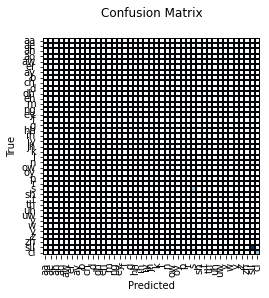

(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix\n'}, xlabel='Predicted', ylabel='True'>)

In [ ]:
# Confusion matrix
cm = pyspch.nn.evaluate_cm(model, test_dl) 

# Phone Error Rate (PER) + PER per phone class
per, per_pc = pyspch.nn.cm2per(cm)
print("PER %.2f " % (per))
if not None in per_pc:
    print("PER per phone class %s" % (np.round(per_pc, 4)))

# Cross-entropy loss
loss = pyspch.nn.evaluate(model, test_dl, criterion)
print("CEL %.2f" % loss)

# plot
pyspch.plot_confusion_matrix(cm, labels, annot=False)

##### Single utterance

In [ ]:
# select file to visualize
example = 'test/dr1/faks0/si2203'

# transcription + word segmentation 
example_txt = pyspch.read_txt(setup.label_path + example + ".txt")
example_wrd = pyspch.read_dataframe(setup.label_path + example + ".wrd", sep=" ", names=['t0','t1','wrd'])

# labels (phone segmentation)
lab_shift = read_feature_args['f_shift'] * read_feature_args['sample_rate']
example_phn = pyspch.timit.read_seg_file(setup.label_path + example + ".phn", fmt="float32")
example_lab = pyspch.seg2lbls(example_phn, lab_shift)
example_lab = [lab2lab[lbl] for lbl in example_lab]
example_idx = [lab2idx[lbl] for lbl in example_lab] # target

# audio
example_audio, _ = pyspch.audio.load(root_url + 'audio/' + example + ".wav", sample_rate=lab_shift)

# feature + modification + splicing
example_feature = np.load(pyspch.read_fobj(setup.feature_path + example + '.npy'))
example_mod = pyspch.sp.feature_extraction(spg=example_feature, **modify_feature_args)
example_spliced = pyspch.sp.splice_frames(example_mod, setup.sampler_args['N'], setup.sampler_args['stride']) # input

# tensor
example_X = torch.tensor(example_spliced).T.float().to(device)
example_y = torch.tensor(example_idx).long().to(device)

In [ ]:
# output for single example utterance 
example_yp = model(example_X) # log probs
example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs

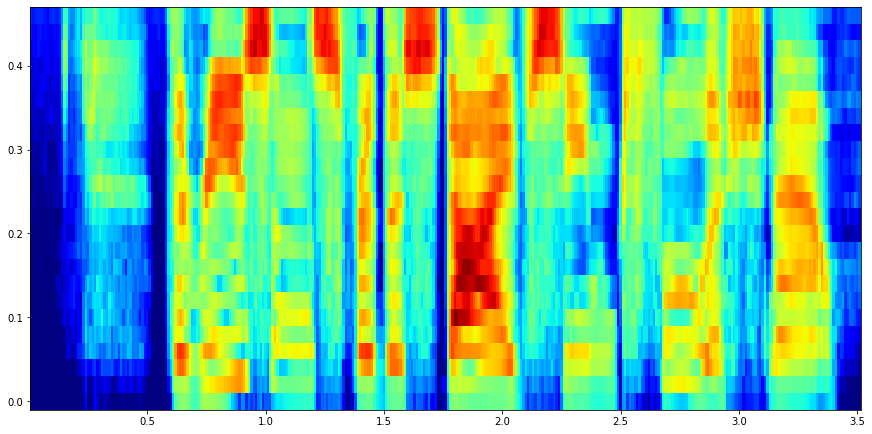

In [ ]:
pyspch.display.PlotSpg(spgdata=example_feature, segspg=example_phn)

#### Model write/read

In [ ]:
# write checkpoint
model_file = "model_eval.pt"
pyspch.nn.write_checkpoint(model_file, setup, lab2idx, model, optimizer, scheduler)

# read checkpoint
model_setup, lab2idx, model, criterion, optimizer, scheduler = pyspch.nn.read_checkpoint(model_file, device)
model = pyspch.nn.get_model(model_setup['model_args'])

# test model 
# -- new setup
new_setup = setup.copy()
new_setup.update(model_setup)
new_setup = dotdict(new_setup)

# feature arguments
feature_path = root_url + 'features/mel24/'
read_feature_args = pyspch.read_json(new_setup.feature_path + 'feature_args.json')
modify_feature_args = pyspch.dct_diff(read_feature_args, new_setup.feature_args)

# Data
dummy_df = pd.read_pickle(new_setup.train_pickle_file)
dummy_data = pyspch.nn.DataFrame_to_SpchData(dummy_df, delete_df=True)
dummy_data = dummy_data.subset(train_corpus)
dummy_data.modify_features(modify_feature_args)
dummy_data.lengths = dummy_data.get_length('features')

# SpchDataset
labels = pyspch.timit.get_timit_alphabet(new_setup.labset_out)
lab2lab = pyspch.timit.get_timit_mapping(new_setup.labset_in, new_setup.labset_out) 
dummy_ds = pyspch.nn.SpchDataset(dummy_data.corpus, dummy_data.features, dummy_data.labels)
dummy_ds.map_target(lab2lab)
dummy_ds.encode_target(lab2idx)
dummy_ds.to_tensor()
dummy_ds.set_sampler(dummy_data.lengths, new_setup.sampler_args)

# device
model.to(device)
dummy_ds.to_device(device)

PER 0.98 
CEL 4.29


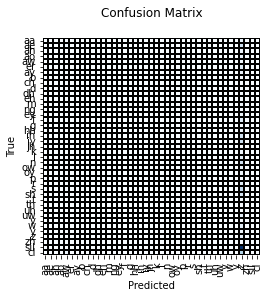

(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix\n'}, xlabel='Predicted', ylabel='True'>)

In [ ]:
# evaluate
loss = pyspch.nn.evaluate(model, test_dl, criterion)
cm = pyspch.nn.evaluate_cm(model, test_dl) 
per, per_pc = pyspch.nn.cm2per(cm)
print("PER %.2f " % (per))
print("CEL %.2f" % loss)
pyspch.plot_confusion_matrix(cm, labels, annot=False)

In [ ]:
# continued training
training_args = new_setup.training_args

# criterion + optimizer + learning rate-scheduler
criterion = pyspch.nn.get_criterion(training_args)
optimizer = pyspch.nn.get_optimizer(training_args, model) 
scheduler = pyspch.nn.get_scheduler(training_args, optimizer)

# validation set (split fraction from train set)
valid_ds, actual_train_ds = train_ds.split(training_args['val_frac'], training_args['val_seed'])
if valid_ds: print(" %d training examples, %d validation files" % (len(train_ds), len(valid_ds)))    
    
# dataloader (train set)
train_dl = torch.utils.data.DataLoader(actual_train_ds, 
    batch_size=training_args['batch_size'],
    shuffle=training_args['shuffle'], 
    num_workers=training_args['num_workers'])

# dataloader (validation set)
if valid_ds is None:
    valid_dl = None
else:
    valid_dl = torch.utils.data.DataLoader(valid_ds, 
        batch_size=training_args['batch_size'],
        shuffle=training_args['shuffle'], 
        num_workers=training_args['num_workers'])

# test logging
logging.info("start training")

# train model 
current_epoch = setup.current_epoch
print_every = setup.print_every
clip_args = training_args['clip_args']
training_args['n_epoch'] = 10

# train
tr_loss, val_loss, last_epoch = pyspch.nn.train(model, train_dl, criterion, optimizer, 
    clip_args=clip_args, scheduler=scheduler,
    current_epoch=current_epoch, n_epochs=training_args['n_epoch'],
    valid_dl=valid_dl, patience=training_args['patience'], 
    every=print_every)

setup.current_epoch = last_epoch

INFO:root:start training


 1461 training examples, 146 validation files


INFO:root:Epoch 10 -- av. train loss per mini-batch 3.39
INFO:root:	 -- av. validation loss per mini-batch 3.24
INFO:root:Epoch 11 -- av. train loss per mini-batch 3.13
INFO:root:	 -- av. validation loss per mini-batch 3.04
INFO:root:Epoch 12 -- av. train loss per mini-batch 2.83
INFO:root:	 -- av. validation loss per mini-batch 2.60
INFO:root:Epoch 13 -- av. train loss per mini-batch 2.54
INFO:root:	 -- av. validation loss per mini-batch 2.57
INFO:root:Epoch 14 -- av. train loss per mini-batch 2.25
INFO:root:	 -- av. validation loss per mini-batch 2.47
INFO:root:Epoch 15 -- av. train loss per mini-batch 1.99
INFO:root:	 -- av. validation loss per mini-batch 2.23
INFO:root:Epoch 16 -- av. train loss per mini-batch 1.79
INFO:root:	 -- av. validation loss per mini-batch 1.97
INFO:root:Epoch 17 -- av. train loss per mini-batch 1.59
INFO:root:	 -- av. validation loss per mini-batch 1.94
INFO:root:Epoch 18 -- av. train loss per mini-batch 1.46
INFO:root:	 -- av. validation loss per mini-bat